# <t1>Optimisation de MLP avec Métaheuristiques & AutoML <t1>
**Projet personnel d’optimisation avancée de modèles MLP**

*Projet réalisé rapidement par pure curiosité. Il manque peut-être un peu de structure, mais l’essentiel est là.*  
<br>


Dans ce notebook, plusieurs méthodes d’optimisation sont testées sur un classifieur MLP, d'abord de façon mono objective, avec :  
1. Algorithme Génétique (GA)  
2. Optimisation Bayésienne (Optuna)  
3. AutoML (TPOT)  
<br>
<br>


L’objectif est d’optimiser la performance du modèle en équilibrant **Score F1, overfitting**.  

Ensuite, de la MOO (Multi Objective Optimization) a été tentée, avec :
1. NSGA-II
2. SMPSO

L’objectif est d’optimiser la performance du modèle en équilibrant **Score F1, overfitting et temps de calcul**.  

#Imports and Basic Classification Problem Creation

In [ ]:
!pip install deap
!pip install optuna
!pip install platypus-opt

from functools import lru_cache

from platypus import Problem, Real, SMPSO, Solution



from deap import base, creator, tools, algorithms
from deap.tools import sortNondominated, emo

import random
import time
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pickle

from joblib import parallel_backend
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor, as_completed



from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report, classification_report, accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 4.5 MB/s eta 0:00:00


In [ ]:
import psutil
import os

print(f"Number of CPU cores: {psutil.cpu_count()}")
print(f"Available RAM: {psutil.virtual_memory().total / (1024.0 ** 3):.1f} GB")

Number of CPU cores: 8
Available RAM: 51.0 GB


In [ ]:
random.seed(42)
np.random.seed(42)

# Step 1: Create a high-dimensional dataset
X, y = make_classification(
    n_samples=3000, n_features=20, n_informative=5,
    n_redundant=10, n_clusters_per_class=4, flip_y=0.1, random_state=42
)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

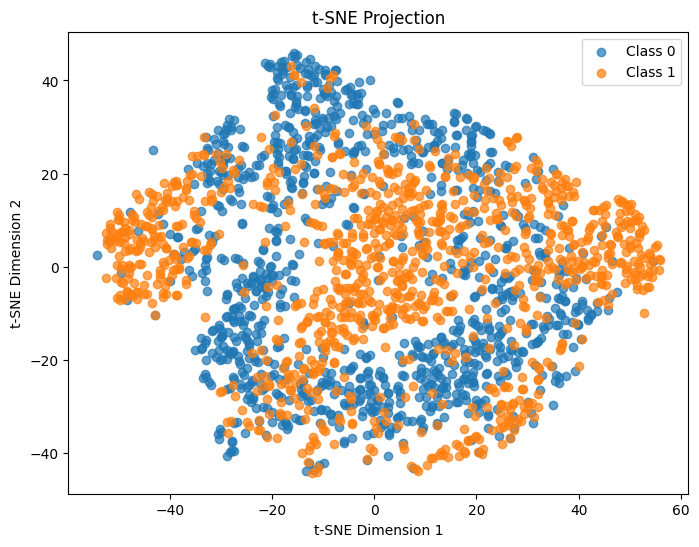

In [ ]:
from sklearn.manifold import TSNE

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[y_train == 0, 0], X_train_tsne[y_train == 0, 1], label="Class 0", alpha=0.7)
plt.scatter(X_train_tsne[y_train == 1, 0], X_train_tsne[y_train == 1, 1], label="Class 1", alpha=0.7)
plt.legend()
plt.title("t-SNE Projection")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


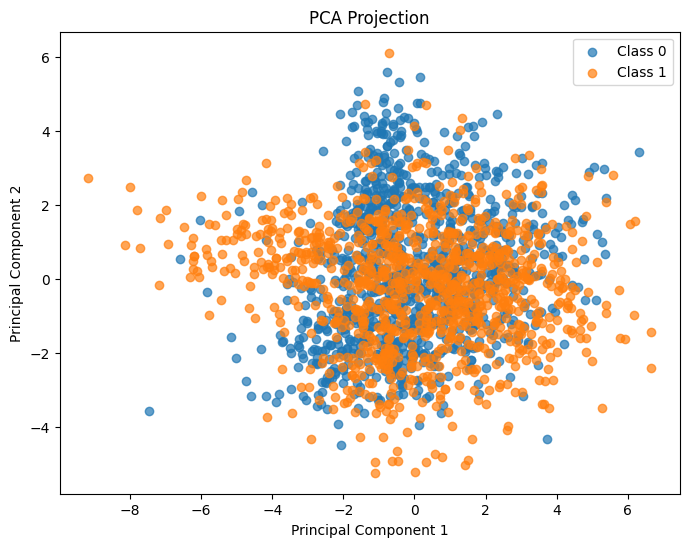

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[y_train == 0, 0], X_train_pca[y_train == 0, 1], label="Class 0", alpha=0.7)
plt.scatter(X_train_pca[y_train == 1, 0], X_train_pca[y_train == 1, 1], label="Class 1", alpha=0.7)
plt.legend()
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


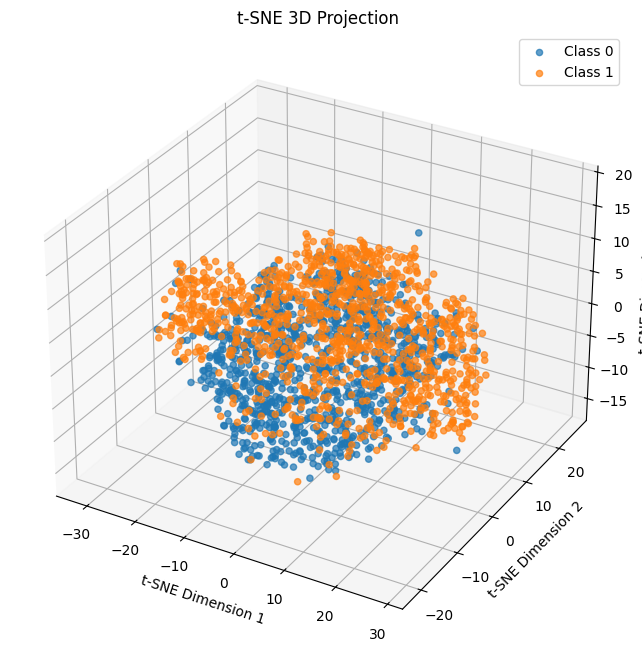

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D using t-SNE
tsne_3d = TSNE(n_components=3, random_state=42)
X_train_tsne_3d = tsne_3d.fit_transform(X_train)

# Visualize in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for class 0
ax.scatter(
    X_train_tsne_3d[y_train == 0, 0],
    X_train_tsne_3d[y_train == 0, 1],
    X_train_tsne_3d[y_train == 0, 2],
    label='Class 0', alpha=0.7
)

# Scatter plot for class 1
ax.scatter(
    X_train_tsne_3d[y_train == 1, 0],
    X_train_tsne_3d[y_train == 1, 1],
    X_train_tsne_3d[y_train == 1, 2],
    label='Class 1', alpha=0.7
)

ax.set_title("t-SNE 3D Projection")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")
ax.legend()
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Prepare the data for Plotly
data = pd.DataFrame({
    'Dimension 1': X_train_tsne_3d[:, 0],
    'Dimension 2': X_train_tsne_3d[:, 1],
    'Dimension 3': X_train_tsne_3d[:, 2],
    'Class': y_train
})

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    data,
    x='Dimension 1',
    y='Dimension 2',
    z='Dimension 3',
    color='Class',
    title='Interactive t-SNE 3D Projection',
    labels={'Class': 'Class Label'}
)
fig.show()


#No Optimization

In [ ]:
# Train a perceptron with 64 neurons in the hidden layer
fixed_neurons = 1
fixed_alpha = 0.1
fixed_learning_rate = 0.1

# Define the model
model = MLPClassifier(
    hidden_layer_sizes=(fixed_neurons,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    learning_rate='adaptive',  # Decreases learning rate if loss stops improving
    learning_rate_init= fixed_learning_rate,
    momentum=0.9,
    alpha = fixed_alpha,
    batch_size=min(200, len(X_train)),  # Optimize batch size
    early_stopping=True,  # Add early stopping
    n_iter_no_change=10,  # Stop if no improvement for 10 iterations
  )

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train_classic = model.predict(X_train)
y_pred_test_classic = model.predict(X_test)

# Evaluate the model
train_f1_classic = f1_score(y_train, y_pred_train_classic)
test_f1_classic = f1_score(y_test, y_pred_test_classic)

print(f"Number of Neurons: {fixed_neurons}")
print(f"Train F1-Score: {train_f1_classic}")
print(f"Test F1-Score: {test_f1_classic}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_classic))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_classic))


Number of Neurons: 1
Train F1-Score: 0.7035376183358246
Test F1-Score: 0.7058823529411765

Confusion Matrix:
[[339 115]
 [140 306]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       454
           1       0.73      0.69      0.71       446

    accuracy                           0.72       900
   macro avg       0.72      0.72      0.72       900
weighted avg       0.72      0.72      0.72       900



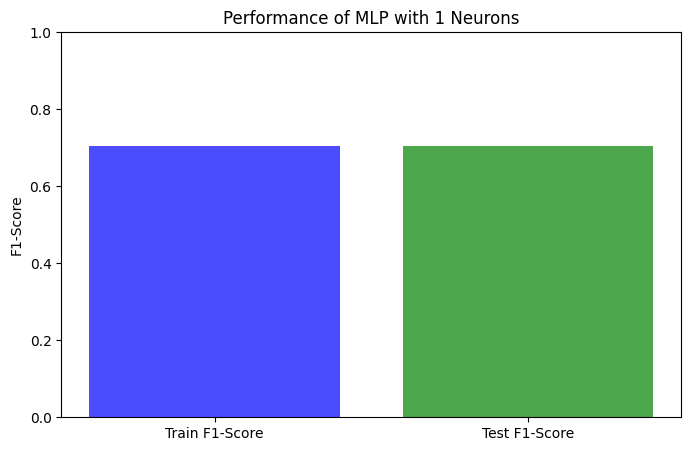

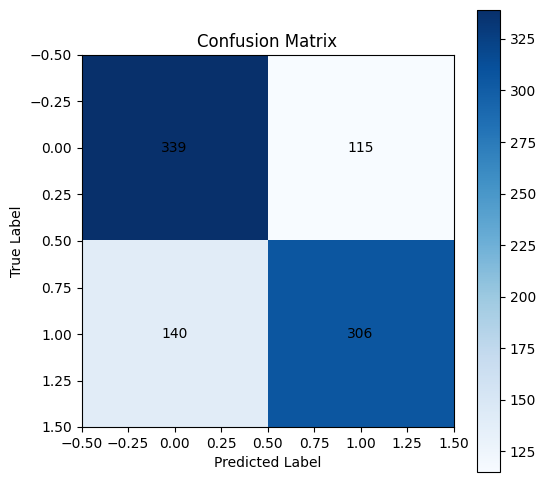

In [ ]:
# Plotting Train and Test F1-Scores
plt.figure(figsize=(8, 5))
f1_scores = [train_f1_classic, test_f1_classic]
labels = ['Train F1-Score', 'Test F1-Score']

plt.bar(labels, f1_scores, color=['blue', 'green'], alpha=0.7)
plt.ylim(0, 1)  # F1-scores range from 0 to 1
plt.ylabel('F1-Score')
plt.title(f"Performance of MLP with {fixed_neurons} Neurons")
plt.show()

# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test_classic)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Annotate the confusion matrix cells with counts
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.show()

#Genetic Algorithm

##Train/Test Split Version

In [ ]:
# Split the training data into train and validation subsets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# DEAP setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

def generate_neurons():
    return random.randint(5, 50)

def generate_alpha():
    return random.uniform(0.01, 5)

def generate_learning_rate():
    return random.uniform(0.001, 0.1)

toolbox.register("neurons", generate_neurons)
toolbox.register("alpha", generate_alpha)
toolbox.register("learning_rate", generate_learning_rate)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.neurons, toolbox.alpha, toolbox.learning_rate), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=50, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


pool = Pool(processes=7)
toolbox.register("map", pool.map)
fitness_cache = {}

# DEAP evaluation remains the same
def evaluate(individual):
    key = tuple(individual)  # Hashable representation of individual
    if key in fitness_cache:  # Check if fitness is already cached
        return fitness_cache[key]

    # Extract hyperparameters
    n_neurons = abs(int(individual[0]))
    if n_neurons < 1:  # Ensure valid number of neurons
        fitness_cache[key] = (0.0,)  # Cache invalid individuals
        return (0.0,)
    alpha = abs(individual[1])
    learning_rate_init = abs(individual[2])

    # Define the MLP model with hyperparameters
    model = MLPClassifier(
        hidden_layer_sizes=(n_neurons,),
        activation='relu',
        solver='adam',
        max_iter=100,
        random_state=42,
        learning_rate='adaptive',
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        momentum=0.9,
        batch_size=min(200, len(X_train)),
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1
    )


    try:
        # Train the model on the training split
        model.fit(X_train_split, y_train_split)

        # Validate the model on the validation split
        y_pred_val = model.predict(X_val_split)
        val_f1 = f1_score(y_val_split, y_pred_val, average='macro')

        # Optional: Compute train F1 for overfitting penalty
        y_pred_train = model.predict(X_train_split)
        train_f1 = f1_score(y_train_split, y_pred_train, average='macro')

        # Overfitting penalty (train vs validation discrepancy)
        overfitting_penalty = abs(train_f1 - val_f1)

        # Penalized fitness score
        fitness = (val_f1 - overfitting_penalty,)
        fitness_cache[key] = fitness  # Store the result in the cache
        return fitness

    except Exception as e:
        print(f"Model training failed: {e}")
        fitness_cache[key] = (0.0,)  # Cache failed evaluations
        return (0.0,)  # Return a zero score for failed evaluations

toolbox.register("evaluate", evaluate)


def parallel_evaluate(individuals):
    with ProcessPoolExecutor() as executor:
        results = executor.map(toolbox.evaluate, individuals)
    return list(results)



/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


##Crossval Version

In [ ]:
# DEAP setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

def generate_neurons():
    return random.randint(5, 50)

def generate_alpha():
    return random.uniform(0.1, 5)

def generate_learning_rate():
    return random.uniform(0.001, 0.1)

toolbox.register("neurons", generate_neurons)
toolbox.register("alpha", generate_alpha)
toolbox.register("learning_rate", generate_learning_rate)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.neurons, toolbox.alpha, toolbox.learning_rate), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=50, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


pool = Pool(processes=7)
toolbox.register("map", pool.map)
fitness_cache = {}

def evaluate(individual):
    key = tuple(individual)  # Hashable representation of individual
    if key in fitness_cache:  # Check if fitness is already cached
        return fitness_cache[key]

    # Extract hyperparameters
    n_neurons = abs(int(individual[0]))
    if n_neurons < 1:  # Ensure valid number of neurons
        fitness_cache[key] = (0.0,)  # Cache invalid individuals
        return (0.0,)
    alpha = abs(individual[1])
    learning_rate_init = abs(individual[2])

    # Define the MLP model with hyperparameters
    model = MLPClassifier(
        hidden_layer_sizes=(n_neurons,),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        learning_rate='adaptive',
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        momentum=0.9,
        batch_size=min(200, len(X_train)),
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1
    )

    # Perform Stratified K-Fold CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 3-fold CV
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_macro')
        mean_cv_score = cv_scores.mean()

        fitness_cache[key] = (mean_cv_score,)  # Cache the result
        return (mean_cv_score,)

    except Exception as e:
        print(f"Model evaluation failed: {e}")
        fitness_cache[key] = (0.0,)  # Cache failed evaluations
        return (0.0,)  # Return a zero score for failed evaluations

toolbox.register("evaluate", evaluate)

def parallel_evaluate(individuals):
    with ProcessPoolExecutor() as executor:
        results = executor.map(toolbox.evaluate, individuals)
    return list(results)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


##Optuna Objective

In [ ]:
# Optuna optimization
def objective(trial):
    pop_size = trial.suggest_int("population_size", 10, 35)
    gen_count = trial.suggest_int("num_generations", 10, 20)
    print(f"Defined pop size as {pop_size} and gen count as {gen_count}")

    # Parallel evaluation using DEAP's built-in functionality
    population = toolbox.population(n=pop_size)
    print("Starting parallel backend")

    for gen in range(gen_count):
        print(f"Generation {gen}")

        # Check which individuals are invalid
        invalid_ind = [ind for ind in population if not ind.fitness.valid]
        print(f"Invalid individuals: {len(invalid_ind)}")

        # Use parallel evaluation, no need for Pool(), just let cross_val_score handle the parallelism
        fitnesses = parallel_evaluate(invalid_ind)
        print("Fitnesses Defined")

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Debug: Print individuals and their fitness
        for i, ind in enumerate(population):
            print(f"Individual {i}: {ind}, Fitness: {ind.fitness.values}")

        # Perform selection and evolution
        elites = tools.selBest(population, 2)  # Preserve top 2 individuals
        offspring_count = max(0, len(population) - len(elites))
        offspring = toolbox.select(population, offspring_count)
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < 0.5:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Combine elites and offspring
        population[:] = elites + offspring

        # Reevaluate invalid individuals
        invalid_ind = [ind for ind in population if not ind.fitness.valid]
        if invalid_ind:
            fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

        # Track and log fitness
        max_fitness = max(ind.fitness.values[0] for ind in population)
        print(f"Max fitness in generation {gen}: {max_fitness}")

    return max(ind.fitness.values[0] for ind in population)

##Optuna Study

In [ ]:
try:
    # Optimize population size and generation count
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10, n_jobs=1)

    # Get the best parameters
    best_population_size = study.best_params["population_size"]
    best_num_generations = study.best_params["num_generations"]

    print("Optimal Population Size:", best_population_size)
    print("Optimal Number of Generations:", best_num_generations)
finally:
    # Ensure the pool is closed and cleaned up after the optimization process
    pool.close()  # Prevent new tasks
    pool.join()   # Wait for all worker processes to finish
    print("Pool closed and joined.")

[I 2024-12-21 20:34:27,286] A new study created in memory with name: no-name-47c97fde-7a9e-4b6a-9838-a01402940f84


Defined pop size as 21 and gen count as 10
Starting parallel backend
Generation 0
Invalid individuals: 21
Fitnesses Defined
Individual 0: [11, 2.4233744289845287, 0.06533408986231497], Fitness: (0.7952393391465982,)
Individual 1: [49, 3.7561600828116113, 0.029856181305942302], Fitness: (0.7901194175907067,)
Individual 2: [16, 4.032422735674844, 0.0584232641801889], Fitness: (0.7895534308297678,)
Individual 3: [9, 1.4498806645088242, 0.010712055075959504], Fitness: (0.7901408267319676,)
Individual 4: [5, 3.3735416969497587, 0.04453486951113017], Fitness: (0.7775244970783484,)
Individual 5: [35, 0.5481455000910175, 0.0747014502021458], Fitness: (0.7996514717944727,)
Individual 6: [14, 3.196635040693173, 0.07666089938927649], Fitness: (0.7892587329508883,)
Individual 7: [46, 3.900736337698268, 0.02916926547971439], Fitness: (0.7759829958306012,)
Individual 8: [16, 1.827280241495117, 0.061563918908113135], Fitness: (0.7984520207685735,)
Individual 9: [49, 2.019511666167338, 0.0553348650543

[I 2024-12-21 20:34:52,556] Trial 0 finished with value: 0.8137512999666056 and parameters: {'population_size': 21, 'num_generations': 10}. Best is trial 0 with value: 0.8137512999666056.


Max fitness in generation 9: 0.8137512999666056
Defined pop size as 32 and gen count as 20
Starting parallel backend
Generation 0
Invalid individuals: 32
Fitnesses Defined
Individual 0: [22, 0.6276951774049283, 0.0713491763350319], Fitness: (0.8105590996168972,)
Individual 1: [41, 4.436406522227398, 0.05796925493788685], Fitness: (0.7805522678615464,)
Individual 2: [46, 1.5434154994502844, 0.06380746143602374], Fitness: (0.8061335668833538,)
Individual 3: [6, 0.5808155303745356, 0.007044421470823917], Fitness: (0.7894499647773746,)
Individual 4: [31, 2.6079729672415692, 0.012321691313075037], Fitness: (0.8064961947587073,)
Individual 5: [19, 0.107331173480174, 0.0752030513347152], Fitness: (0.8077312609746607,)
Individual 6: [5, 1.1748093454515232, 0.03948086688042617], Fitness: (0.8012060823536945,)
Individual 7: [10, 1.323060779646565, 0.08702730835313369], Fitness: (0.8018627813462977,)
Individual 8: [45, 3.2433596455601648, 0.0681558970150473], Fitness: (0.7860316678116582,)
Indivi

[I 2024-12-21 20:36:13,191] Trial 1 finished with value: 0.8160559340124817 and parameters: {'population_size': 32, 'num_generations': 20}. Best is trial 1 with value: 0.8160559340124817.


Max fitness in generation 19: 0.8160559340124817
Defined pop size as 13 and gen count as 12
Starting parallel backend
Generation 0
Invalid individuals: 13
Fitnesses Defined
Individual 0: [15, 1.5006680654473146, 0.024069141238168848], Fitness: (0.8077742944183672,)
Individual 1: [5, 1.985784334496529, 0.03225713757888163], Fitness: (0.7964836109239937,)
Individual 2: [24, 3.167622585444886, 0.017410768592355137], Fitness: (0.7994459344945349,)
Individual 3: [11, 0.10814679726596498, 0.009510830918165281], Fitness: (0.778913744299104,)
Individual 4: [25, 0.3268590290526238, 0.055514560436791295], Fitness: (0.8143603228121847,)
Individual 5: [19, 2.3812692090232686, 0.0027264917914382415], Fitness: (0.793741118896981,)
Individual 6: [33, 3.079769499380164, 0.006867337810989284], Fitness: (0.7971864352017162,)
Individual 7: [18, 0.3148391428966782, 0.01876552417521719], Fitness: (0.8085666344767919,)
Individual 8: [45, 0.8363339291753391, 0.08738556188893261], Fitness: (0.7856551988210544

[I 2024-12-21 20:36:32,668] Trial 2 finished with value: 0.8143603228121847 and parameters: {'population_size': 13, 'num_generations': 12}. Best is trial 1 with value: 0.8160559340124817.


Max fitness in generation 11: 0.8143603228121847
Defined pop size as 21 and gen count as 15
Starting parallel backend
Generation 0
Invalid individuals: 21
Fitnesses Defined
Individual 0: [6, 1.590594317427049, 0.06207365367519708], Fitness: (0.7895905099514571,)
Individual 1: [7, 3.116853582181012, 0.09401355765367772], Fitness: (0.7818815408463371,)
Individual 2: [28, 2.81627482004164, 0.028403758235327838], Fitness: (0.7951456016757357,)
Individual 3: [38, 3.8343730056380267, 0.02518064772936234], Fitness: (0.8007744684084857,)
Individual 4: [48, 3.7692063597972325, 0.05964539439920275], Fitness: (0.7823558371067928,)
Individual 5: [27, 2.0964528307621895, 0.032383827688538834], Fitness: (0.7934569652431966,)
Individual 6: [31, 1.7240580994821175, 0.04155056449200577], Fitness: (0.808731907486974,)
Individual 7: [30, 1.2043865401990828, 0.005466506625346272], Fitness: (0.8094229624381043,)
Individual 8: [40, 0.05697587756530355, 0.09311893973386953], Fitness: (0.8129479173756564,)
In

[I 2024-12-21 20:37:09,038] Trial 3 finished with value: 0.8161518029921656 and parameters: {'population_size': 21, 'num_generations': 15}. Best is trial 3 with value: 0.8161518029921656.


Max fitness in generation 14: 0.8161518029921656
Defined pop size as 22 and gen count as 19
Starting parallel backend
Generation 0
Invalid individuals: 22
Fitnesses Defined
Individual 0: [19, 4.639433473243602, 0.042611935375464004], Fitness: (0.7836652916261928,)
Individual 1: [24, 4.416180932093485, 0.07406594386101967], Fitness: (0.7797792629149981,)
Individual 2: [31, 1.878132368931043, 0.08087513734274876], Fitness: (0.7855975280964451,)
Individual 3: [50, 4.6868652616810085, 0.03719533604983794], Fitness: (0.7802192923195352,)
Individual 4: [35, 4.361221311031329, 0.05421800930931778], Fitness: (0.7795257188703935,)
Individual 5: [27, 2.296007676847962, 0.007459807654093061], Fitness: (0.8032205734660256,)
Individual 6: [33, 0.455879400786607, 0.02915618013924038], Fitness: (0.8206531572428151,)
Individual 7: [15, 0.8470618460814654, 0.007916601991386028], Fitness: (0.792650407989682,)
Individual 8: [22, 3.74006875848537, 0.05937336716400232], Fitness: (0.7804166767796367,)
Indiv

[I 2024-12-21 20:37:42,155] Trial 4 finished with value: 0.8206531572428151 and parameters: {'population_size': 22, 'num_generations': 19}. Best is trial 4 with value: 0.8206531572428151.


Max fitness in generation 18: 0.8206531572428151
Defined pop size as 19 and gen count as 20
Starting parallel backend
Generation 0
Invalid individuals: 19
Fitnesses Defined
Individual 0: [11, 1.9084385359086105, 0.0726925073962865], Fitness: (0.7982592532130741,)
Individual 1: [22, 1.3070741190991093, 0.020312895547754287], Fitness: (0.81686860791354,)
Individual 2: [25, 2.751538012859075, 0.07752875517714895], Fitness: (0.7901336235453703,)
Individual 3: [16, 1.5112523175025225, 0.044568901019384856], Fitness: (0.7982280804902524,)
Individual 4: [8, 3.992372370873172, 0.05547172143533747], Fitness: (0.7914887093935097,)
Individual 5: [22, 4.920235150634694, 0.03202025735505948], Fitness: (0.7893536864668746,)
Individual 6: [22, 1.1909654842047999, 0.08126034895774797], Fitness: (0.8015261794999369,)
Individual 7: [35, 0.355137941561749, 0.01350740004658816], Fitness: (0.8167802093849172,)
Individual 8: [30, 4.284822147923303, 0.05799409252141576], Fitness: (0.7917864070507973,)
Indivi

[I 2024-12-21 20:38:18,346] Trial 5 finished with value: 0.81686860791354 and parameters: {'population_size': 19, 'num_generations': 20}. Best is trial 4 with value: 0.8206531572428151.


Max fitness in generation 19: 0.81686860791354
Defined pop size as 26 and gen count as 13
Starting parallel backend
Generation 0
Invalid individuals: 26
Fitnesses Defined
Individual 0: [33, 2.9581072924487195, 0.06617786633599068], Fitness: (0.7934452436254544,)
Individual 1: [28, 3.593708660433116, 0.04319736236218959], Fitness: (0.7911961169365329,)
Individual 2: [17, 2.479455977840349, 0.025285927268461447], Fitness: (0.8052223069281134,)
Individual 3: [49, 3.4475661277068625, 0.06977279749146142], Fitness: (0.7926551463715034,)
Individual 4: [10, 2.0302171635831727, 0.09909139245024828], Fitness: (0.7962141416502694,)
Individual 5: [36, 3.1314875512654474, 0.03132462722896702], Fitness: (0.798048893000458,)
Individual 6: [36, 1.9163865797219277, 0.03757602067002183], Fitness: (0.799665398341384,)
Individual 7: [26, 4.880584366956807, 0.03039490075620462], Fitness: (0.7848558206230848,)
Individual 8: [29, 3.5583369768664888, 0.016240252970708646], Fitness: (0.8037004919755149,)
Indi

[I 2024-12-21 20:39:14,596] Trial 6 finished with value: 0.8159249911171388 and parameters: {'population_size': 26, 'num_generations': 13}. Best is trial 4 with value: 0.8206531572428151.


Max fitness in generation 12: 0.8159249911171388
Defined pop size as 31 and gen count as 15
Starting parallel backend
Generation 0
Invalid individuals: 31
Fitnesses Defined
Individual 0: [13, 3.8561463282120525, 0.026484384815639573], Fitness: (0.796594110843861,)
Individual 1: [40, 2.208880602258937, 0.09555962555753682], Fitness: (0.8023506827169367,)
Individual 2: [20, 0.13039294170167107, 0.04868711665518953], Fitness: (0.8053380062502594,)
Individual 3: [39, 1.0769200068687306, 0.0672245265698442], Fitness: (0.8099454491603814,)
Individual 4: [34, 4.878154026306579, 0.05527538574256652], Fitness: (0.777312015823442,)
Individual 5: [12, 0.16798510916034748, 0.019517959469948647], Fitness: (0.8090590260830448,)
Individual 6: [22, 2.3931389766078603, 0.09715342012057313], Fitness: (0.785584780706569,)
Individual 7: [33, 1.1072929139088654, 0.032556599332101525], Fitness: (0.8079508374922287,)
Individual 8: [25, 2.6818738608302093, 0.08332702906192009], Fitness: (0.7939639552830317,)


[I 2024-12-21 20:40:07,438] Trial 7 finished with value: 0.8170591854764716 and parameters: {'population_size': 31, 'num_generations': 15}. Best is trial 4 with value: 0.8206531572428151.


Max fitness in generation 14: 0.8170591854764716
Defined pop size as 21 and gen count as 15
Starting parallel backend
Generation 0
Invalid individuals: 21
Fitnesses Defined
Individual 0: [31, 2.4159319664131593, 0.012274240196436664], Fitness: (0.8041074977861975,)
Individual 1: [44, 0.4899000807348062, 0.07341996825140347], Fitness: (0.80806391091809,)
Individual 2: [11, 2.044352857153677, 0.09014372639686435], Fitness: (0.7907222629396327,)
Individual 3: [12, 3.9315525042612864, 0.03940690025056652], Fitness: (0.7789835946977648,)
Individual 4: [41, 2.194269380521478, 0.08074964218285084], Fitness: (0.7838677730479792,)
Individual 5: [20, 2.913663444714069, 0.08324516031005272], Fitness: (0.7760404956504992,)
Individual 6: [25, 1.0949534499380509, 0.08503482486639141], Fitness: (0.8063277317618001,)
Individual 7: [15, 4.7834036579167405, 0.0034840847632723534], Fitness: (0.7626991231720146,)
Individual 8: [40, 2.1722163090831415, 0.03510666041178319], Fitness: (0.7948341784787601,)
I

[I 2024-12-21 20:40:39,730] Trial 8 finished with value: 0.8182319888300779 and parameters: {'population_size': 21, 'num_generations': 15}. Best is trial 4 with value: 0.8206531572428151.


Max fitness in generation 14: 0.8182319888300779
Defined pop size as 24 and gen count as 20
Starting parallel backend
Generation 0
Invalid individuals: 24
Fitnesses Defined
Individual 0: [21, 3.692573820206981, 0.08647473069065253], Fitness: (0.7842578961792546,)
Individual 1: [18, 3.397395688073045, 0.062053432185666994], Fitness: (0.7948626901712474,)
Individual 2: [12, 3.6402070311161534, 0.09805293408207952], Fitness: (0.7824187917490477,)
Individual 3: [29, 4.717514707238408, 0.09987826568918695], Fitness: (0.7782444808216065,)
Individual 4: [43, 4.362295588647541, 0.09274223529795461], Fitness: (0.7608761664274429,)
Individual 5: [28, 4.674217527973272, 0.004414788398849442], Fitness: (0.7856264802296162,)
Individual 6: [40, 4.654399017619852, 0.026543271052290894], Fitness: (0.7902149134087348,)
Individual 7: [33, 2.0391532118049516, 0.08176206249880752], Fitness: (0.7982528558497807,)
Individual 8: [34, 3.0400892156663932, 0.08027031074229574], Fitness: (0.7851426165893738,)
In

[I 2024-12-21 20:41:16,070] Trial 9 finished with value: 0.8045117500060667 and parameters: {'population_size': 24, 'num_generations': 20}. Best is trial 4 with value: 0.8206531572428151.


Max fitness in generation 19: 0.8045117500060667
Optimal Population Size: 22
Optimal Number of Generations: 19
Pool closed and joined.


##Run

In [ ]:
# Use the optimized parameters to initialize the population and generations
population = toolbox.population(n=best_population_size)
num_generations = best_num_generations

#Manual Values
population = toolbox.population(n=50)
num_generations = 50

patience = 10  # Number of generations to wait for improvement
epsilon = 1e-4  # Minimum improvement to reset patience
no_improve_count = 0  # Counter for no improvement
best_fitness = -float("inf")  # Initialize to negative infinity


# Ensure the initial population has valid fitness values
invalid_ind = [ind for ind in population if not ind.fitness.valid]
for ind in invalid_ind:
    ind.fitness.values = toolbox.evaluate(ind)

# Run your GA with early stopping
for gen in range(num_generations):
    print(f"Generation {gen}")

    # Select the next generation
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:  # Crossover probability
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:  # Mutation probability
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Recalculate fitness for invalid offspring
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        ind.fitness.values = toolbox.evaluate(ind)

    # Replace the population with the offspring
    population[:] = offspring

    # Track and log maximum fitness
    current_best_fitness = max(ind.fitness.values[0] for ind in population)
    print(f"Max fitness in generation {gen}: {current_best_fitness}")

    # Check for improvement
    if current_best_fitness - best_fitness > epsilon:
        best_fitness = current_best_fitness
        no_improve_count = 0  # Reset the counter
    else:
        no_improve_count += 1

    # Early stopping condition
    if no_improve_count >= patience:
        print(f"Early stopping triggered at generation {gen}.")
        break

Generation 0
Max fitness in generation 0: 0.8170001024191345
Generation 1
Max fitness in generation 1: 0.8170001024191345
Generation 2
Max fitness in generation 2: 0.8170001024191345
Generation 3
Max fitness in generation 3: 0.8170001024191345
Generation 4
Max fitness in generation 4: 0.8220436665327103
Generation 5
Max fitness in generation 5: 0.8220436665327103
Generation 6
Max fitness in generation 6: 0.8220436665327103
Generation 7
Max fitness in generation 7: 0.8220436665327103
Generation 8
Max fitness in generation 8: 0.8220436665327103
Generation 9
Max fitness in generation 9: 0.8220436665327103
Generation 10
Max fitness in generation 10: 0.8220436665327103
Generation 11
Max fitness in generation 11: 0.8220436665327103
Generation 12
Max fitness in generation 12: 0.8220436665327103
Generation 13
Max fitness in generation 13: 0.8220436665327103
Generation 14
Max fitness in generation 14: 0.8223028422919686
Generation 15
Max fitness in generation 15: 0.8223028422919686
Generation 1

In [ ]:
# Get the best individual from the final population based on fitness
best_individual = max(population, key=lambda ind: ind.fitness.values[0])

# Print or return the best individual (genome) and its fitness
print("Best individual:", best_individual)
print("Best fitness:", best_individual.fitness.values)


Best individual: [50.75517770923196, 0.5730708289258308, 0.01656793960999583]
Best fitness: (0.8223028422919686,)


##Results

In [ ]:
# Get the optimal number of neurons from the best individual
optimal_neurons = int(abs(best_individual[0]))  # Extracted from the genetic algorithm
optimal_learning_rate = abs(best_individual[1])
optimal_alpha = abs(best_individual[2])

# Train the perceptron with the optimal number of neurons
model = MLPClassifier(
            hidden_layer_sizes=(optimal_neurons,),
            activation='relu',
            solver='adam',
            max_iter=1000,
            random_state=42,
            learning_rate='adaptive',
            learning_rate_init=optimal_learning_rate,
            alpha=optimal_alpha,
            momentum=0.9,
            batch_size=min(200, len(X_train)),
            early_stopping=True,
            n_iter_no_change=10,
            validation_fraction=0.1
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)

print(f"Optimal Number of Neurons: {optimal_neurons}")
print(f"Train F1-Score: {train_f1}")
print(f"Test F1-Score: {test_f1}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

Optimal Number of Neurons: 50
Train F1-Score: 0.818
Test F1-Score: 0.7906432748538011

Confusion Matrix:
[[383  71]
 [108 338]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       454
           1       0.83      0.76      0.79       446

    accuracy                           0.80       900
   macro avg       0.80      0.80      0.80       900
weighted avg       0.80      0.80      0.80       900



The genetic algorithm performs well enough but is outperformed by Bayesian optimization and other approaches in this case. Genetic algorithms excel in exploring large, unstructured search spaces, but this problem has a relatively well-defined and low-complexity parameter space. The genetic algorithm's reliance on random exploration and population-based evolution leads to higher computational costs and a greater risk of overfitting.

While genetic algorithms might excel with more complex objectives (e.g., varying layers or architecture), they are less suited to problems like this where parameter relationships are clearer and wide exploration isn't needed.

#Bayesian Optimisation

In [ ]:
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.7 MB/s eta 0:00:00


In [ ]:
# Define the parameter search space
search_space = {
    'hidden_layer_sizes': Integer(10, 200),
    'learning_rate_init': Real(1e-5, 1e-1, prior='log-uniform'),
    'alpha': Real(1e-5, 1e-1, prior='log-uniform')
}

# Define the MLPClassifier with a fixed set of parameters
mlp = MLPClassifier(
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    learning_rate='adaptive',
    momentum=0.9,
    batch_size=min(200, len(X_train)),
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

# Perform Bayesian optimization using cross-validation to evaluate each combination
bayes_search = BayesSearchCV(
    estimator=mlp,
    search_spaces=search_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=2
)


bayes_search.fit(X_train, y_train)
print("Best hyperparameters:", bayes_search.best_params_)

best_model = bayes_search.best_estimator_
score = best_model.score(X_test, y_test)
print(f"Best model test score: {score:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
y_pred_train_bay = best_model.predict(X_train)
y_pred_test_bay = best_model.predict(X_test)


# Evaluate the model
train_f1_bay = f1_score(y_train, y_pred_train_bay)
test_f1_bay = f1_score(y_test, y_pred_test_bay)

optimal_parameters = bayes_search.best_params_
print("Optimal Parameters:")
for param, value in optimal_parameters.items():
    print(f"{param}: {value}")

optimal_neurons_bay = optimal_parameters['hidden_layer_sizes']
optimal_learning_rate_bay = optimal_parameters['learning_rate_init']
optimal_alpha_bay = optimal_parameters['alpha']

print(f"Optimal Number of Neurons: {optimal_neurons_bay}")
print(f"Optimal Initial Learning Rate: {optimal_learning_rate_bay}")
print(f"Optimal alpha: {optimal_alpha_bay}")
print(f"Train F1-Score: {train_f1_bay}")
print(f"Test F1-Score: {test_f1_bay}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_bay))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_bay))

Optimal Parameters:
alpha: 0.1
hidden_layer_sizes: 10
learning_rate_init: 0.1
Optimal Number of Neurons: 10
Optimal Initial Learning Rate: 0.1
Optimal alpha: 0.1
Train F1-Score: 0.8316642823080591
Test F1-Score: 0.8070175438596491

Confusion Matrix:
[[356  98]
 [ 78 368]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       454
           1       0.79      0.83      0.81       446

    accuracy                           0.80       900
   macro avg       0.80      0.80      0.80       900
weighted avg       0.81      0.80      0.80       900



Bayesian optimization leverages prior evaluations to intelligently search the parameter space, resulting in faster convergence and slightly better performance. The more balanced train-test F1-scores indicate reduced overfitting compared to the GA. Its efficiency and precision make it well-suited for the low-complexity parameter space of this problem.

#TPOT

In [ ]:
!pip install tpot
from tpot import TPOTClassifier

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 4.9 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=9dbdf71f57a3f9bda570db1bae84c8b55449141ea191836d1a6a6ad7fcc6fe0e
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
from tpot import TPOTClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Define a custom configuration dictionary to force TPOT to use MLPClassifier
mlp_config = {
    'sklearn.neural_network.MLPClassifier': {
        'hidden_layer_sizes': [(10,), (50,), (100,)],  # Matches (n_neurons,)
        'activation': ['relu'],  # Matches activation='relu'
        'solver': ['adam'],  # Matches solver='adam'
        'max_iter': [1000],  # Matches max_iter=1000
        'random_state': [42],  # Matches random_state=42
        'learning_rate': ['adaptive'],  # Matches learning_rate='adaptive'
        'learning_rate_init': [0.001, 0.01, 0.1, 1],  # Matches learning_rate_init=learning_rate_init
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],  # Matches alpha=alpha
        'momentum': [0.9],  # Matches momentum=0.9
        'batch_size':[min(200, len(X_train))],
        'early_stopping': [True],  # Matches early_stopping=True
        'n_iter_no_change': [10],  # Matches n_iter_no_change=10
        'validation_fraction': [0.1]  # Matches validation_fraction=0.1
    }
}

# Initialize TPOT with the custom configuration
tpot = TPOTClassifier(
    generations=5,  # Number of iterations
    population_size=20,  # Number of models in each generation
    cv=5,
    random_state=42,
    verbosity=2,
    config_dict=mlp_config  # Force TPOT to use MLPClassifier
)

# Fit the TPOT model to the data
tpot.fit(X_train, y_train)

# Print the best model and evaluate it
print(f"Best model test score: {tpot.score(X_test, y_test):.4f}")

is_classifier


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8190476190476191

Generation 2 - Current best internal CV score: 0.8190476190476191

Generation 3 - Current best internal CV score: 0.822857142857143

Generation 4 - Current best internal CV score: 0.822857142857143

Generation 5 - Current best internal CV score: 0.822857142857143

Best pipeline: MLPClassifier(MLPClassifier(input_matrix, activation=relu, alpha=0.01, batch_size=200, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, max_iter=1000, momentum=0.9, n_iter_no_change=10, random_state=42, solver=adam, validation_fraction=0.1), activation=relu, alpha=0.1, batch_size=200, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, max_iter=1000, momentum=0.9, n_iter_no_change=10, random_state=42, solver=adam, validation_fraction=0.1)
Best model test score: 0.8133


In [ ]:
# Get the best model from TPOT
best_model = tpot.fitted_pipeline_

# Print the best model pipeline (optional)
print("Best model pipeline:")
print(best_model)


train_f1 = f1_score(y_train, y_train_pred, average='macro')  # Use 'macro' for balanced classes

# Optional: Detailed metrics
print(f"Train F1-Score: {train_f1:.4f}")

# Evaluate the model on the test data
test_score = best_model.score(X_test, y_test)
print(f"Best model test score (Accuracy): {test_score:.4f}")

# Get predictions from the model
y_pred = best_model.predict(X_test)

y_train_pred = best_model.predict(X_train)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best model pipeline:
Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=MLPClassifier(alpha=0.01,
                                                           batch_size=200,
                                                           early_stopping=True,
                                                           hidden_layer_sizes=(50,),
                                                           learning_rate='adaptive',
                                                           learning_rate_init=0.1,
                                                           max_iter=1000,
                                                           random_state=42))),
                ('mlpclassifier',
                 MLPClassifier(alpha=0.1, batch_size=200, early_stopping=True,
                               learning_rate='adaptive', learning_rate_init=0.1,
                               max_iter=1000, random_state=42))])
Train F1-Score: 0.8585
Best model test score (Acc

TPOT, leveraging its genetic algorithm-inspired approach, explores a broad range of hyperparameter configurations and pipeline architectures. This method yields competitive results with a high test F1-score and the best train F1-score among the methods, highlighting its ability to find well-performing solutions. However, the larger discrepancy between train and test F1-scores suggests a tendency toward overfitting, likely due to its focus on maximizing fitness across multiple pipeline components.

Like GA, TPOT shines in more complex or high-dimensional problems, but in this low-complexity parameter space, its exploratory nature adds unnecessary complexity, slightly limiting its generalizability compared to Bayesian optimization.

#Analysis of Optimization Approaches


This experiment compared three optimization techniques for tuning an MLP classifier: Genetic Algorithm, Bayesian Optimization, and TPOT (Tree-based Pipeline Optimization Tool).

**TPOT (GA-based Auto-ML)** achieved the highest test F1-Score (0.82) but exhibited moderate overfitting, with a train F1-Score of 0.8585. The overfitting may stem from its genetic algorithm-inspired architecture, which explores a broad parameter space but can overemphasize local optima, especially in smaller or simpler parameter spaces. TPOT's added model complexity likely contributed to its strong test performance but reduced generalization.

**Bayesian Search** Optimization performed slightly behind TPOT, achieving a test F1-Score of 0.807 with minimal overfitting. Its focus on probabilistically modeling the parameter space enabled it to identify optimal hyperparameters efficiently without the risk of overfitting, making it a strong choice for this relatively straightforward problem.

**Genetic Algorithm**, while functional, delivered the weakest test F1-Score (0.79) and suffered from computational inefficiencies during its optuna optimization. While genetic algorithms excel in unstructured and highly complex search spaces, their reliance on population evolution and random exploration made them less effective for this low search space.

**Conclusion:** In this specific case, TPOT delivered the best test performance (F1 Score = 0.82), but its moderate overfitting (Train F1 Score = 0.85) highlights the risk of using GA-like architectures in simpler problems. Bayesian Optimization offered a more balanced and generalizable solution, making it the preferred approach for this case. The GA wasn't too far off in score from the Bayesian Optimization, but it also took significantly longer to run.
<br>
<br>
<br>

# **Big-O Complexity of our optimization algorithms**

Complexity theory is relatively new to me, so I may be very wrong. I would love to be corrected by people who know their math.

## **Bayesian Search Complexity Expression**
$$
O(G_B \times (N_B^3 + cv \times T))
$$

where:
- $ G_B $ = Number of Bayesian Optimization iterations  
- $ N_B $ = Number of past evaluations stored in the Gaussian Process  
- $ cv $ = Number of cross-validation folds (from `BayesSearchCV`)  
- $ T $ = Complexity of model Training

## **Genetic Algorithm Complexity Expression**
$$
O(G_G \times N_G \times \frac{T}{C})
$$

where:
- $ G_G $ = Number of generations  
- $ N_G $ = Population size  
- $ T $ = Complexity of model Training (one individual)
- $ C $ = Number of CPU cores (parallel evaluation of individuals)

In our caase, mutation takes an insignificant amount of time and has been ignored.

$$Do \ note \ that \ \ \frac{T}{C} \ would \ have \ been \ replaced \ by \ T_{gpu} \ if \ we \ were \ using \ a \ GPU. $$

This does not count the optuna process in complexity for the GA, by the way.

<br>
<br>

## Algorithm comparison :

Let us assume GPU usage and remove C to get a clearer general picture:
$$
O(G_B \times (N_B^3 + cv \times T)) \quad \text{vs.} \quad O(G_G \times N_G \times T)
$$

We know that $G_B$ is almost always smaller than $G_G$, so we can assume that.
This leads to a situation where if model training is expensive, Bayesian Search is typically more efficient than a Genetic Algorithm due to its lower number of function evaluations.

However, if model training is cheap enough, the cost of maintaining the Gaussian Process ($N_B^3$) can become a bottleneck, making Genetic Algorithms more competitive. This is rarely the case in practice.

While this was not in either of my comlpexity expressions, because the sources I had found online did not mention dimensionality in their expressions, it is important to know the following:

Genetic Algorithms are **much** better than Bayesian Optimization at handling high dimensionality. If one were to also optimize the number of neurons per layer as well as the number of layers, then the maximum number of layers (let's call it $L_{max}$) would also be a very important factor to take into consideration, since dimensionality would be around $2 L_{max} + e$ with e being the number of other hyperparameters that are being optimized.

Perhaps trying to look into cheaper GA-like architectures like Evolutionary Strategies (ES) could be quite relevant.







# Multi-Objective Optimization

##NSGA-II

###Evaluate

In [ ]:
# Multiprocessing pool
toolbox = base.Toolbox()
fitness_cache = {}
pool_executor = ProcessPoolExecutor(max_workers=7)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def evaluate(individual, skf=skf):
    try:
        key = tuple(individual)
        if key in fitness_cache:
            print(f"DEBUG: Using cached fitness for {key}")
            return fitness_cache[key]

        neurons, lr, alpha = abs(int(individual[0])), abs(individual[1]), abs(individual[2])
        if neurons < 1:
            return (0.0, float('inf'))

        start = time.time()
        model = MLPClassifier(
            hidden_layer_sizes=(neurons,),
            learning_rate_init=lr,
            alpha=alpha,
            solver="adam",
            max_iter=100,
            learning_rate='adaptive',
            random_state=42,
            batch_size=min(200, len(X_train)),
            early_stopping=True,
            n_iter_no_change=10,
        )

        # Manual cross-validation
        scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            model.fit(X_train[train_idx], y_train[train_idx])
            preds = model.predict(X_train[val_idx])
            scores.append(f1_score(y_train[val_idx], preds, average="macro"))

        mean_cv_score = np.mean(scores)
        duration = time.time() - start

        fitness = (mean_cv_score, duration)
        fitness_cache[key] = fitness
        return fitness
    except Exception as e:
        print(f"ERROR in evaluate: {e}")
        return (0.0, float('inf'))



def parallel_evaluate(evaluate_func, individuals):
    try:
        print(f"DEBUG: parallel_evaluate called with {len(individuals)} individuals.")
        results = pool_executor.map(evaluate_func, individuals, chunksize=max(1, len(individuals) // 7))
        return list(results)
    except Exception as e:
        print(f"ERROR in parallel_evaluate: {e}")
        raise


def correct_individual(individual):
    # Ensure valid neurons, learning rate, and alpha
    individual[0] = abs(int(individual[0]))  # Neurons must be a positive integer
    individual[1] = abs(individual[1])  # Learning rate must be positive
    individual[2] = abs(individual[2])  # Alpha must be positive
    return individual



### Setup the DEAP Framework

In [ ]:
toolbox.register("evaluate", evaluate)
toolbox.register("map", parallel_evaluate)
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox.register("attr_neurons", random.randint, 10, 200)
toolbox.register("attr_lr", lambda: round(random.uniform(1e-5, 1e-1), 3))  # 3 decimal places
toolbox.register("attr_alpha", lambda: round(random.uniform(1e-5, 1e-1), 3))  # 3 decimal places
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_neurons, toolbox.attr_lr, toolbox.attr_alpha), n=1)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

def init_corrected_individual():
    ind = toolbox.individual()
    return correct_individual(ind)

toolbox.register("individual_corrected", init_corrected_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual_corrected)


### OPTUNA Tuning

#### OPTUNA Setup

In [ ]:
def objective(trial):
    pop_size = trial.suggest_int("population_size", 28, 40, step=4)  # Suggest multiples of 4
    ngen = trial.suggest_int("num_generations", 56, 80)
    print(f"Starting trial with pop_size={pop_size}, ngen={ngen}")

    # Initialize population
    population = toolbox.population(n=pop_size)

    # Ensure all individuals have valid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    if invalid_ind:
        print(f"DEBUG: Evaluating {len(invalid_ind)} invalid individuals")
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            if fit is None or len(fit) != 2:  # Check for invalid fitness
                print(f"Invalid fitness detected for {ind}: {fit}")
                fit = (0.0, float('inf'))  # Assign default invalid fitness
            ind.fitness.values = fit



    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)

    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Run the genetic algorithm
    for gen in range(ngen):
        print(f"Generation {gen}")

        invalid_ind = [ind for ind in population if not ind.fitness.valid]
        if invalid_ind:
            fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

        if all(ind.fitness.values == population[0].fitness.values for ind in population):
            print("Convergence reached. Stopping early.")
            break

        fronts = tools.sortNondominated(population, len(population), first_front_only=False)
        for front in fronts:
            tools.emo.assignCrowdingDist(front)

        elite_count = max(1, len(population) // 10)  # Top 10% as elites
        sorted_population = sorted(population, key=lambda ind: ind.fitness.values, reverse=True)
        elites = sorted_population[:elite_count]

        offspring = tools.selTournamentDCD(population, len(population) - elite_count)
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.7:
                toolbox.mate(child1, child2)
                correct_individual(child1)
                correct_individual(child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.1:
                toolbox.mutate(mutant)
                correct_individual(mutant)
                del mutant.fitness.values

        population[:] = offspring + elites

    # Use the Pareto front to determine the outcome
    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
    valid_individuals = [ind for ind in pareto_front if ind.fitness.valid]

    if not valid_individuals:
        print("WARNING: No valid individuals in Pareto front.")
        return 0.0  # Fallback value for Optuna

    return valid_individuals[0].fitness.values[0]  # Return the first valid individual's fitness



#### OPTUNA Run

In [ ]:
try:
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=4)

    optimal_pop = study.best_params["population_size"]
    optimal_gens = study.best_params["num_generations"]
    print("Best population size:", optimal_pop)
    print("Best number of generations:", optimal_gens)

finally:
    pool_executor.shutdown()
    print("Pool closed and joined.")

[I 2024-12-22 16:51:05,401] A new study created in memory with name: no-name-9a2c31fa-dc10-44c4-be93-77882f871e31


Starting trial with pop_size=32, ngen=58
DEBUG: Evaluating 32 invalid individuals
DEBUG: parallel_evaluate called with 32 individuals.
DEBUG: Using cached fitness for (145, 0.022, 0.094)
DEBUG: Using cached fitness for (17, 0.026, 0.084)
DEBUG: Using cached fitness for (199, 0.054, 0.028)
DEBUG: Using cached fitness for (168, 0.039, 0.016)DEBUG: parallel_evaluate called with 32 individuals.

Generation 0
Generation 1
DEBUG: parallel_evaluate called with 28 individuals.
Generation 2
DEBUG: parallel_evaluate called with 28 individuals.
Generation 3
DEBUG: parallel_evaluate called with 28 individuals.
Generation 4
DEBUG: parallel_evaluate called with 17 individuals.
Generation 5
DEBUG: parallel_evaluate called with 24 individuals.
Generation 6
DEBUG: parallel_evaluate called with 27 individuals.
Generation 7
DEBUG: parallel_evaluate called with 19 individuals.
Generation 8
DEBUG: parallel_evaluate called with 22 individuals.
Generation 9
DEBUG: parallel_evaluate called with 21 individuals

[I 2024-12-22 16:57:31,904] Trial 0 finished with value: 0.8091359425288461 and parameters: {'population_size': 32, 'num_generations': 58}. Best is trial 0 with value: 0.8091359425288461.


Starting trial with pop_size=40, ngen=66
DEBUG: Evaluating 40 invalid individuals
DEBUG: parallel_evaluate called with 40 individuals.
DEBUG: Using cached fitness for (193, 0.046, 0.064)
DEBUG: Using cached fitness for (69, 0.084, 0.064)
DEBUG: parallel_evaluate called with 40 individuals.
DEBUG: Using cached fitness for (130, 0.076, 0.004)
DEBUG: Using cached fitness for (67, 0.018, 0.058)
DEBUG: Using cached fitness for (117, 0.075, 0.072)
DEBUG: Using cached fitness for (125, 0.033, 0.075)
DEBUG: Using cached fitness for (137, 0.09, 0.026)
DEBUG: Using cached fitness for (97, 0.012, 0.0)
DEBUG: Using cached fitness for (148, 0.028, 0.053)
DEBUG: Using cached fitness for (21, 0.059, 0.07)
Generation 0
Generation 1
DEBUG: parallel_evaluate called with 24 individuals.
Generation 2
DEBUG: parallel_evaluate called with 26 individuals.
Generation 3
DEBUG: parallel_evaluate called with 34 individuals.
Generation 4
DEBUG: parallel_evaluate called with 20 individuals.
Generation 5
DEBUG: par

[I 2024-12-22 17:08:58,044] Trial 1 finished with value: 0.7965483440496738 and parameters: {'population_size': 40, 'num_generations': 66}. Best is trial 0 with value: 0.8091359425288461.


Starting trial with pop_size=40, ngen=80
DEBUG: Evaluating 40 invalid individuals
DEBUG: parallel_evaluate called with 40 individuals.
DEBUG: Using cached fitness for (164, 0.096, 0.0)
DEBUG: Using cached fitness for (185, 0.033, 0.04)
DEBUG: Using cached fitness for (118, 0.09, 0.065)
DEBUG: Using cached fitness for (63, 0.076, 0.003)
DEBUG: Using cached fitness for (29, 0.04, 0.09)
DEBUG: Using cached fitness for (167, 0.034, 0.051)
DEBUG: parallel_evaluate called with 40 individuals.
DEBUG: Using cached fitness for (140, 0.086, 0.058)
DEBUG: Using cached fitness for (84, 0.076, 0.054)
DEBUG: Using cached fitness for (124, 0.064, 0.046)
DEBUG: Using cached fitness for (85, 0.058, 0.015)
Generation 0
Generation 1
DEBUG: parallel_evaluate called with 23 individuals.
Generation 2
DEBUG: parallel_evaluate called with 24 individuals.
Generation 3
DEBUG: parallel_evaluate called with 29 individuals.
DEBUG: Using cached fitness for (51, 0.03991510058882644, 0.03428039764107536)
Generation 4

[I 2024-12-22 17:22:05,508] Trial 2 finished with value: 0.8224460780901146 and parameters: {'population_size': 40, 'num_generations': 80}. Best is trial 2 with value: 0.8224460780901146.


Starting trial with pop_size=40, ngen=64
DEBUG: Evaluating 40 invalid individuals
DEBUG: parallel_evaluate called with 40 individuals.
ERROR in evaluate: The 'learning_rate_init' parameter of MLPClassifier must be a float in the range (0.0, inf). Got 0.0 instead.
DEBUG: Using cached fitness for (28, 0.014, 0.04)
DEBUG: Using cached fitness for (184, 0.062, 0.012)
DEBUG: Using cached fitness for (196, 0.085, 0.084)
DEBUG: Using cached fitness for (50, 0.073, 0.098)
DEBUG: Using cached fitness for (125, 0.067, 0.068)
DEBUG: parallel_evaluate called with 40 individuals.
ERROR in evaluate: The 'learning_rate_init' parameter of MLPClassifier must be a float in the range (0.0, inf). Got 0.0 instead.
Generation 0
Generation 1
DEBUG: parallel_evaluate called with 30 individuals.
Generation 2
DEBUG: parallel_evaluate called with 28 individuals.
Generation 3
DEBUG: parallel_evaluate called with 26 individuals.
Generation 4
DEBUG: parallel_evaluate called with 32 individuals.
Generation 5
DEBUG: 

[I 2024-12-22 17:31:43,115] Trial 3 finished with value: 0.8054100919464485 and parameters: {'population_size': 40, 'num_generations': 64}. Best is trial 2 with value: 0.8224460780901146.


Best population size: 40
Best number of generations: 80
Pool closed and joined.


###Run

In [ ]:
population = toolbox.population(n=optimal_pop)
NGEN = optimal_gens

for gen in range(NGEN):
    print(f"Generation {gen + 1}/{NGEN}")

    try:
        invalid_ind = [ind for ind in population if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
    except Exception as e:
        print(f"Error during fitness evaluation: {e}")

    print(f"DEBUG: Population at generation {gen + 1}")
    for ind in population:
        print(f"Individual: {ind}, Fitness: {ind.fitness.values}")

    fronts = tools.sortNondominated(population, len(population), first_front_only=False)
    for front in fronts:
        tools.emo.assignCrowdingDist(front)

    offspring = tools.selTournamentDCD(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.7:
            toolbox.mate(child1, child2)
            correct_individual(child1)
            correct_individual(child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            correct_individual(mutant)
            del mutant.fitness.values

    population[:] = offspring



Generation 1/80
DEBUG: Using cached fitness for (196, 0.063, 0.021)
DEBUG: Population at generation 1
Individual: [184, 0.091, 0.077], Fitness: (0.7994294422080336, 0.9231860637664795)
Individual: [27, 0.087, 0.052], Fitness: (0.8057632743626596, 0.3338632583618164)
Individual: [69, 0.073, 0.04], Fitness: (0.7922847021729305, 0.34116125106811523)
Individual: [21, 0.07, 0.042], Fitness: (0.8055400938141952, 0.2624485492706299)
Individual: [118, 0.06, 0.054], Fitness: (0.8046712187715149, 0.533076286315918)
Individual: [77, 0.049, 0.051], Fitness: (0.8076445927274177, 0.41328930854797363)
Individual: [17, 0.076, 0.04], Fitness: (0.7970510328831706, 0.2026207447052002)
Individual: [137, 0.085, 0.093], Fitness: (0.7784159213385341, 0.36780858039855957)
Individual: [122, 0.017, 0.056], Fitness: (0.8100979822552176, 0.5259087085723877)
Individual: [19, 0.056, 0.014], Fitness: (0.7949921255633751, 0.2340238094329834)
Individual: [26, 0.04, 0.031], Fitness: (0.7988682317506927, 0.2902560234069

### Retrieve Pareto Front

In [ ]:
pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
valid_individuals = [ind for ind in pareto_front if ind.fitness.valid]

if not valid_individuals:
    raise ValueError("No valid individuals in Pareto front.")

print("Pareto front individuals and their fitness:")
for ind in valid_individuals:
    print(f"Neurons={int(ind[0])}, LR={ind[1]:.5f}, Alpha={ind[2]:.5f}, "
          f"F1={ind.fitness.values[0]:.5f}, Time={ind.fitness.values[1]:.2f}s")


Pareto front individuals and their fitness:
Neurons=10, LR=0.10982, Alpha=0.00036, F1=0.79497, Time=0.12s
Neurons=11, LR=0.04637, Alpha=0.17842, F1=0.79837, Time=0.17s
Neurons=36, LR=0.03125, Alpha=0.02702, F1=0.80261, Time=0.20s
Neurons=36, LR=0.03125, Alpha=0.02702, F1=0.80261, Time=0.20s
Neurons=113, LR=0.07507, Alpha=0.04589, F1=0.80512, Time=0.40s


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

results = []
for individual in valid_individuals:
    neurons = int(individual[0])  # Extract the number of neurons
    lr = individual[1]           # Extract the learning rate
    alpha = individual[2]        # Extract the alpha value
    time_taken = individual.fitness.values[1]  # Extract the time taken during evaluation

    # Define the model
    model = MLPClassifier(
        hidden_layer_sizes=(neurons,),
        learning_rate_init=lr,
        alpha=alpha,
        solver="adam",
        max_iter=1000,
        learning_rate='adaptive',
        random_state=42,
        momentum=0.9,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1
    )


    # Cross-validation
    y_cv_pred = cross_val_predict(model, X_train, y_train, cv=5)  # 5-fold CV
    cv_accuracy = accuracy_score(y_train, y_cv_pred)
    cv_f1 = classification_report(y_train, y_cv_pred, output_dict=True)["macro avg"]["f1-score"]
    cv_conf_matrix = confusion_matrix(y_train, y_cv_pred)
    cv_class_report = classification_report(y_train, y_cv_pred)

    # Fit on training data and evaluate on test set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = classification_report(y_test, y_test_pred, output_dict=True)["macro avg"]["f1-score"]
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_class_report = classification_report(y_test, y_test_pred)

    # Store results
    results.append({
        "neurons": neurons,
        "lr": lr,
        "alpha": alpha,
        "time_taken": time_taken,
        "cv_accuracy": cv_accuracy,
        "cv_f1_score": cv_f1,
        "cv_conf_matrix": cv_conf_matrix,
        "cv_class_report": cv_class_report,
        "test_accuracy": test_accuracy,
        "test_f1_score": test_f1,
        "test_conf_matrix": test_conf_matrix,
        "test_class_report": test_class_report
    })

# Display results
for res in results:
    print(f"Neurons: {res['neurons']}, LR: {res['lr']:.5f}, Alpha: {res['alpha']:.5f}, "
          f"Time: {res['time_taken']:.2f}s")
    print("Cross-Validation Results:")
    print(f"CV Accuracy: {res['cv_accuracy']:.5f}, CV F1 Score: {res['cv_f1_score']:.5f}")
    print("CV Confusion Matrix:")
    print(res["cv_conf_matrix"])
    print("CV Classification Report:")
    print(res["cv_class_report"])
    print("-" * 50)
    print("Test Set Results:")
    print(f"Test Accuracy: {res['test_accuracy']:.5f}, Test F1 Score: {res['test_f1_score']:.5f}")
    print("Test Confusion Matrix:")
    print(res["test_conf_matrix"])
    print("Test Classification Report:")
    print(res["test_class_report"])
    print("=" * 50)

Neurons: 10, LR: 0.10982, Alpha: 0.00036, Time: 0.12s
Cross-Validation Results:
CV Accuracy: 0.80524, CV F1 Score: 0.80445
CV Confusion Matrix:
[[912 143]
 [266 779]]
CV Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82      1055
           1       0.84      0.75      0.79      1045

    accuracy                           0.81      2100
   macro avg       0.81      0.80      0.80      2100
weighted avg       0.81      0.81      0.80      2100

--------------------------------------------------
Test Set Results:
Test Accuracy: 0.80333, Test F1 Score: 0.80300
Test Confusion Matrix:
[[380  74]
 [103 343]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       454
           1       0.82      0.77      0.79       446

    accuracy                           0.80       900
   macro avg       0.80      0.80      0.80       900
weighted avg      

##SMPSO

In [ ]:
# Define the total evaluations and swarm size
total_evaluations = 1000
swarm_size = 50

# Define a cached evaluation function
@lru_cache(maxsize=5000)  # Cache up to 5000 unique solutions
def evaluate_with_cache(neurons, lr, alpha):
    neurons = max(1, int(neurons))
    lr = abs(lr)
    alpha = abs(alpha)

    start_time = time.time()
    model = MLPClassifier(
        hidden_layer_sizes=(neurons,),
        learning_rate_init=lr,
        alpha=alpha,
        solver="adam",
        max_iter=200,
        learning_rate='adaptive',
        random_state=42,
        momentum=0.9,
        batch_size=min(200, len(X_train)),
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1
    )

    model.fit(X_train, y_train)
    f1 = cross_val_score(model, X_train, y_train, cv=3, scoring="f1_macro").mean()
    time_taken = time.time() - start_time
    return f1, time_taken

# Wrapper for the problem evaluation
def evaluate(individual):
    return evaluate_with_cache(individual[0], individual[1], individual[2])

# Define the optimization problem
problem = Problem(3, 2)  # 3 decision variables, 2 objectives
problem.types[:] = [Real(1, 200), Real(1e-5, 1e-1), Real(1e-5, 1e-1)]  # Bounds for variables
problem.directions[:] = [Problem.MAXIMIZE, Problem.MINIMIZE]  # Maximize F1, minimize time
problem.function = evaluate  # Use the cached evaluate function

# Set up SMPSO
swarm_size = 50
total_evaluations = 1000
algorithm = SMPSO(problem, swarm_size=swarm_size)

# Run the optimization
start_time = time.time()
for i in range(total_evaluations // swarm_size):
    algorithm.step()
    elapsed = time.time() - start_time
    print(f"Iteration {i+1}/{total_evaluations // swarm_size}, Elapsed Time: {elapsed:.2f}s, Evaluations: {algorithm.nfe}/{total_evaluations}")

# Display the Pareto front
print("\nPareto front:")
for solution in algorithm.result:
    print(f"Neurons: {int(solution.variables[0])}, LR: {solution.variables[1]:.5f}, "
          f"Alpha: {solution.variables[2]:.5f}, F1: {solution.objectives[0]:.5f}, "
          f"Time: {solution.objectives[1]:.2f}s")

Iteration 1/20, Elapsed Time: 29.89s, Evaluations: 50/1000
Iteration 2/20, Elapsed Time: 60.89s, Evaluations: 100/1000
Iteration 3/20, Elapsed Time: 88.20s, Evaluations: 150/1000
Iteration 4/20, Elapsed Time: 115.97s, Evaluations: 200/1000
Iteration 5/20, Elapsed Time: 139.55s, Evaluations: 250/1000
Iteration 6/20, Elapsed Time: 160.97s, Evaluations: 300/1000
Iteration 7/20, Elapsed Time: 183.48s, Evaluations: 350/1000
Iteration 8/20, Elapsed Time: 208.56s, Evaluations: 400/1000
Iteration 9/20, Elapsed Time: 233.19s, Evaluations: 450/1000
Iteration 10/20, Elapsed Time: 250.61s, Evaluations: 500/1000
Iteration 11/20, Elapsed Time: 269.12s, Evaluations: 550/1000
Iteration 12/20, Elapsed Time: 284.31s, Evaluations: 600/1000
Iteration 13/20, Elapsed Time: 299.36s, Evaluations: 650/1000
Iteration 14/20, Elapsed Time: 314.18s, Evaluations: 700/1000
Iteration 15/20, Elapsed Time: 331.27s, Evaluations: 750/1000
Iteration 16/20, Elapsed Time: 345.58s, Evaluations: 800/1000
Iteration 17/20, Elap

### Why do you take so Long ? A Well-Needed Profiling Session

In [ ]:
import cProfile
import pstats
from io import StringIO

# Set up profiling for one step
pr = cProfile.Profile()
pr.enable()

algorithm.step()  # Profile this single step

pr.disable()
s = StringIO()
ps = pstats.Stats(pr, stream=s)
ps.sort_stats('time').print_stats()
print(s.getvalue())


Parallel evaluations in progress...
Evaluation time: 0.40 seconds
Parallel evaluations in progress...
Evaluation time: 0.99 seconds
Parallel evaluations in progress...
Evaluation time: 0.41 seconds
Parallel evaluations in progress...
Evaluation time: 0.58 seconds
Parallel evaluations in progress...
Evaluation time: 0.36 seconds
Parallel evaluations in progress...
Evaluation time: 0.58 seconds
Parallel evaluations in progress...
Evaluation time: 0.43 seconds
Parallel evaluations in progress...
Evaluation time: 0.52 seconds
Parallel evaluations in progress...
Evaluation time: 0.39 seconds
Parallel evaluations in progress...
Evaluation time: 0.63 seconds
Parallel evaluations in progress...
Evaluation time: 0.30 seconds
Parallel evaluations in progress...
Evaluation time: 0.36 seconds
Parallel evaluations in progress...
Evaluation time: 0.37 seconds
Parallel evaluations in progress...
Evaluation time: 0.83 seconds
Parallel evaluations in progress...
Evaluation time: 0.79 seconds
Parallel e

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation time: 1.75 seconds
Parallel evaluations in progress...
Evaluation time: 1.03 seconds
Parallel evaluations in progress...
Evaluation time: 0.56 seconds
Parallel evaluations in progress...
Evaluation time: 0.75 seconds
Parallel evaluations in progress...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation time: 1.83 seconds
Parallel evaluations in progress...
Evaluation time: 0.73 seconds
Parallel evaluations in progress...
Evaluation time: 0.78 seconds
         12488683 function calls (12463816 primitive calls) in 29.647 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   198512    5.550    0.000    6.167    0.000 /usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:153(safe_sparse_dot)
    37712    2.862    0.000    2.862    0.000 /usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_base.py:130(inplace_relu_derivative)
    37712    1.045    0.000    1.798    0.000 /usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_base.py:203(binary_log_loss)
    37712    1.021    0.000    1.021    0.000 /usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_stochastic_optimizers.py:283(<listcomp>)
    37712    0.998    0.000    3.813    0.000 /usr/local/lib/python3.10/dist-packages/sk

###Apply

In [ ]:
results_SMPSO = []

# Evaluate and analyze each solution in the Pareto front
for solution in algorithm.result:
    neurons = int(solution.variables[0])  # Extract the number of neurons
    lr = solution.variables[1]           # Extract the learning rate
    alpha = solution.variables[2]        # Extract the alpha value
    time_taken = solution.objectives[1]  # Extract the time taken during evaluation

# Define the model
    model = MLPClassifier(
        hidden_layer_sizes=(neurons,),
        learning_rate_init=lr,
        alpha=alpha,
        solver="adam",
        max_iter=1000,
        learning_rate='adaptive',
        random_state=42,
        momentum=0.9,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1
    )


    # Cross-validation
    y_cv_pred = cross_val_predict(model, X_train, y_train, cv=5)  # 5-fold CV
    cv_accuracy = accuracy_score(y_train, y_cv_pred)
    cv_f1 = classification_report(y_train, y_cv_pred, output_dict=True)["macro avg"]["f1-score"]
    cv_conf_matrix = confusion_matrix(y_train, y_cv_pred)
    cv_class_report = classification_report(y_train, y_cv_pred)

    # Fit on training data and evaluate on test set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = classification_report(y_test, y_test_pred, output_dict=True)["macro avg"]["f1-score"]
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_class_report = classification_report(y_test, y_test_pred)

    # Store results
    results_SMPSO.append({
        "neurons": neurons,
        "lr": lr,
        "alpha": alpha,
        "time_taken": time_taken,
        "cv_accuracy": cv_accuracy,
        "cv_f1_score": cv_f1,
        "cv_conf_matrix": cv_conf_matrix,
        "cv_class_report": cv_class_report,
        "test_accuracy": test_accuracy,
        "test_f1_score": test_f1,
        "test_conf_matrix": test_conf_matrix,
        "test_class_report": test_class_report
    })

# Display results
for res in results_SMPSO:
    print(f"Neurons: {res['neurons']}, LR: {res['lr']:.5f}, Alpha: {res['alpha']:.5f}, "
          f"Time: {res['time_taken']:.2f}s")
    print("Cross-Validation Results:")
    print(f"CV Accuracy: {res['cv_accuracy']:.5f}, CV F1 Score: {res['cv_f1_score']:.5f}")
    print("CV Confusion Matrix:")
    print(res["cv_conf_matrix"])
    print("CV Classification Report:")
    print(res["cv_class_report"])
    print("-" * 50)
    print("Test Set Results:")
    print(f"Test Accuracy: {res['test_accuracy']:.5f}, Test F1 Score: {res['test_f1_score']:.5f}")
    print("Test Confusion Matrix:")
    print(res["test_conf_matrix"])
    print("Test Classification Report:")
    print(res["test_class_report"])
    print("=" * 50)

Neurons: 2, LR: 0.00001, Alpha: 0.03932, Time: 0.13s
Cross-Validation Results:
CV Accuracy: 0.48762, CV F1 Score: 0.47383
CV Confusion Matrix:
[[682 373]
 [703 342]]
CV Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.65      0.56      1055
           1       0.48      0.33      0.39      1045

    accuracy                           0.49      2100
   macro avg       0.49      0.49      0.47      2100
weighted avg       0.49      0.49      0.47      2100

--------------------------------------------------
Test Set Results:
Test Accuracy: 0.48444, Test F1 Score: 0.47240
Test Confusion Matrix:
[[286 168]
 [296 150]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.63      0.55       454
           1       0.47      0.34      0.39       446

    accuracy                           0.48       900
   macro avg       0.48      0.48      0.47       900
weighted avg       

-------------------------------

##Results

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

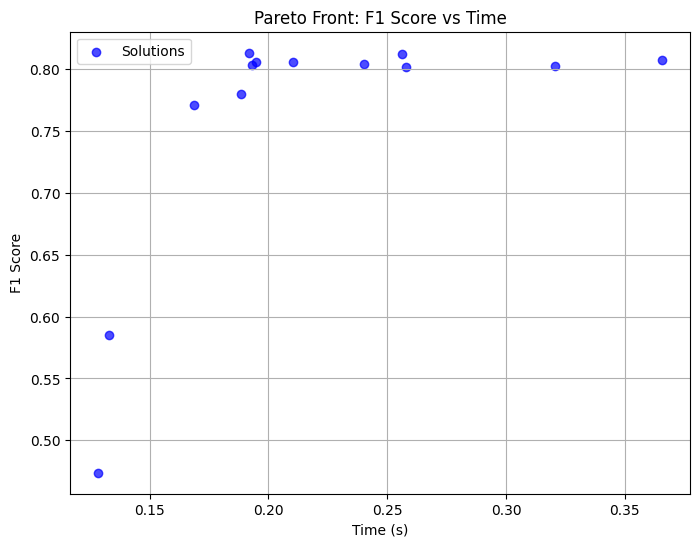

In [ ]:
# Extract F1 and Time from results
f1_scores = [res['cv_f1_score'] for res in results_SMPSO]
times = [res['time_taken'] for res in results_SMPSO]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(times, f1_scores, color='blue', alpha=0.7, label="Solutions")
plt.title("Pareto Front: F1 Score vs Time")
plt.xlabel("Time (s)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()


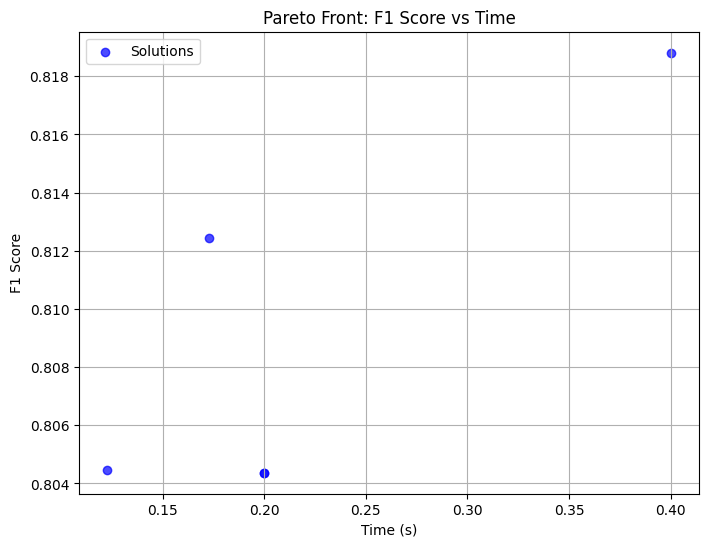

In [ ]:
import matplotlib.pyplot as plt

# Extract F1 and Time from results
f1_scores = [res['cv_f1_score'] for res in results]
times = [res['time_taken'] for res in results]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(times, f1_scores, color='blue', alpha=0.7, label="Solutions")
plt.title("Pareto Front: F1 Score vs Time")
plt.xlabel("Time (s)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
smpso_data = pd.DataFrame(results_SMPSO)
nsga_ii_data = pd.DataFrame(results)

smpso_data['algorithm'] = 'SMPSO'
nsga_ii_data['algorithm'] = 'NSGA-II'

In [ ]:
nsga_ii_data

,neurons,lr,alpha,time_taken,cv_accuracy,cv_f1_score,cv_conf_matrix,cv_class_report,test_accuracy,test_f1_score,test_conf_matrix,test_class_report,algorithm
0,10,0.109815,0.000361,0.122601,0.805238,0.804454,"[[912, 143], [266, 779]]",precision recall f1-score ...,0.803333,0.803000,"[[380, 74], [103, 343]]",precision recall f1-score ...,NSGA-II
1,11,0.046373,0.178425,0.172953,0.812857,0.812440,"[[903, 152], [241, 804]]",precision recall f1-score ...,0.805556,0.805544,"[[366, 88], [87, 359]]",precision recall f1-score ...,NSGA-II
2,36,0.031249,0.027025,0.199927,0.804762,0.804370,"[[892, 163], [247, 798]]",precision recall f1-score ...,0.812222,0.810532,"[[408, 46], [123, 323]]",precision recall f1-score ...,NSGA-II
3,36,0.031249,0.027025,0.199927,0.804762,0.804370,"[[892, 163], [247, 798]]",precision recall f1-score ...,0.812222,0.810532,"[[408, 46], [123, 323]]",precision recall f1-score ...,NSGA-II
4,113,0.075066,0.045889,0.400144,0.819048,0.818810,"[[898, 157], [223, 822]]",precision recall f1-score ...,0.798889,0.798429,"[[381, 73], [108, 338]]",precision recall f1-score ...,NSGA-II


In [ ]:
smpso_data

,neurons,lr,alpha,time_taken,cv_accuracy,cv_f1_score,cv_conf_matrix,cv_class_report,test_accuracy,test_f1_score,test_conf_matrix,test_class_report,algorithm
0,2,0.000010,0.039323,0.128412,0.487619,0.473826,"[[682, 373], [703, 342]]",precision recall f1-score ...,0.484444,0.472397,"[[286, 168], [296, 150]]",precision recall f1-score ...,SMPSO
1,29,0.073270,0.059492,0.365542,0.807619,0.806924,"[[911, 144], [260, 785]]",precision recall f1-score ...,0.808889,0.808511,"[[384, 70], [102, 344]]",precision recall f1-score ...,SMPSO
2,6,0.000010,0.007268,0.132782,0.596190,0.585320,"[[796, 259], [589, 456]]",precision recall f1-score ...,0.608889,0.600022,"[[341, 113], [239, 207]]",precision recall f1-score ...,SMPSO
3,4,0.050641,0.051925,0.168698,0.770952,0.770705,"[[844, 211], [270, 775]]",precision recall f1-score ...,0.782222,0.781947,"[[368, 86], [110, 336]]",precision recall f1-score ...,SMPSO
4,34,0.083512,0.058041,0.320516,0.802381,0.802332,"[[859, 196], [219, 826]]",precision recall f1-score ...,0.783333,0.781564,"[[393, 61], [134, 312]]",precision recall f1-score ...,SMPSO
5,18,0.074583,0.023044,0.257787,0.801905,0.801764,"[[870, 185], [231, 814]]",precision recall f1-score ...,0.813333,0.812708,"[[392, 62], [106, 340]]",precision recall f1-score ...,SMPSO
6,12,0.080796,0.092224,0.240256,0.803810,0.803552,"[[882, 173], [239, 806]]",precision recall f1-score ...,0.818889,0.818701,"[[383, 71], [92, 354]]",precision recall f1-score ...,SMPSO
7,9,0.052324,0.074945,0.210295,0.806190,0.805930,"[[885, 170], [237, 808]]",precision recall f1-score ...,0.794444,0.794168,"[[374, 80], [105, 341]]",precision recall f1-score ...,SMPSO
8,4,0.074721,0.087973,0.188500,0.779524,0.779413,"[[842, 213], [250, 795]]",precision recall f1-score ...,0.783333,0.783138,"[[366, 88], [107, 339]]",precision recall f1-score ...,SMPSO
9,11,0.046785,0.026518,0.256132,0.812381,0.812217,"[[884, 171], [223, 822]]",precision recall f1-score ...,0.805556,0.805544,"[[366, 88], [87, 359]]",precision recall f1-score ...,SMPSO


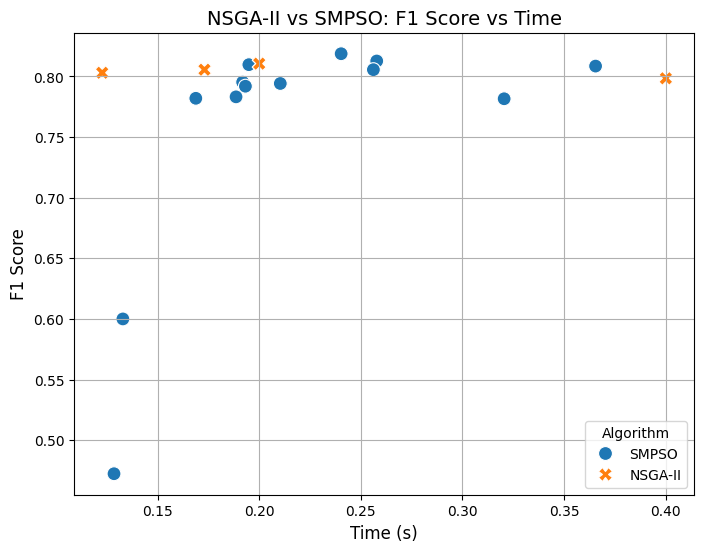

In [ ]:
# Convert results into DataFrames
smpso_data = pd.DataFrame(results_SMPSO)
nsga_ii_data = pd.DataFrame(results)

# Add algorithm labels
smpso_data['Algorithm'] = 'SMPSO'
nsga_ii_data['Algorithm'] = 'NSGA-II'

# Combine data into a single DataFrame
combined_data = pd.concat([smpso_data, nsga_ii_data], ignore_index=True)

# Combined NSGA-II and SMPSO Results Plot (F1 Score vs. Time)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=combined_data, x="time_taken", y="test_f1_score", hue="Algorithm", style="Algorithm", s=100
)
plt.title("NSGA-II vs SMPSO: F1 Score vs Time", fontsize=14)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.legend(title="Algorithm")
plt.grid(True)
plt.show()

# Heatmaps for Hyperparameters and F1 Scores
heatmap_data_nsga = combined_data[combined_data["Algorithm"] == "NSGA-II"].pivot_table(
    index="lr", columns="alpha", values="test_f1_score"
)
heatmap_data_smpso = combined_data[combined_data["Algorithm"] == "SMPSO"].pivot_table(
    index="lr", columns="alpha", values="test_f1_score"
)
